In [93]:
# Spark libs
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import SQLContext
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Others
import pandas as pd
import numpy as np
import datetime
import time

# Graphs libs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_dt

# S3 Service
import boto3
from io import StringIO

# Let's use Amazon S3
s3 = boto3.resource('s3')

spark.version

'2.2.0'

In [94]:
OBV_i = True
CCI_i = True
RSI_i = True
MACD_i = True
ManualSplit = False
Date_Convert = False

DEBUG = False

DT = True
RT = False
GBT = False


RANDOM_SEED = 1

In [95]:
def RSI(dataframe, window_length, avg_type, column='Close'):
    data = dataframe.toPandas()
    # Get just the close
    close = data['Close']
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous
    # row to calculate the differences
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    if avg_type == "EWMA":
        roll_up = up.ewm(span=window_length, min_periods=window_length).mean()
        roll_down = down.abs().ewm(
            span=window_length, min_periods=window_length).mean()
    elif avg_type == "SMA":
        roll_up = pd.rolling_mean(up, window_length)
        roll_down = pd.rolling_mean(down.abs(), window_length)
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    RSI = pd.DataFrame({'RSI': RSI})
    data = data.join(RSI)
    result_df = spark.createDataFrame(data)
    return result_df

In [96]:
# Commodity Channel Index
def CCI(spark_df, ndays):
    data = spark_df.toPandas()
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    CCI = pd.Series(
        (TP - pd.rolling_mean(TP, ndays)) /
        (0.015 * pd.rolling_std(TP, ndays)),
        name='CCI')
    data = data.join(CCI)
    result_df = spark.createDataFrame(data)
    return result_df

In [97]:
# Moving average convergence divergence
def MACD(dataframe, nfast=12, nslow=24, column='Close'):
    data = dataframe.toPandas()
    # Get just the close
    price = data[column]
    # Get the difference in price from previous step
    emaslow = pd.ewma(price, span=nslow, min_periods=1)
    emafast = pd.ewma(price, span=nfast, min_periods=1)
    #     MACD = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    MACD = pd.DataFrame({'MACD': emafast - emaslow})
    data = data.join(MACD)
    result_df = spark.createDataFrame(data)
    return result_df

In [98]:
# Spark context simple configuration
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

#Path to file with CSV
path_to_csv = "s3://stocksets100/Orlen.csv"

fresh_df = spark.read.csv(path_to_csv, header=True, inferSchema=True)

temporary_df = fresh_df.select(
    fresh_df["Date"].cast("Date"), fresh_df["Open"].cast("float"),
    fresh_df["High"].cast("float"), fresh_df["Volume"].cast("int"),
    fresh_df["Low"].cast("float"), fresh_df["Close"].cast("float"))

df_cleared = temporary_df.filter(temporary_df.Open.isNotNull())

if DEBUG:
    df_cleared.show()

# Creating new column with shifted Close price by 1 day
df_lag = df_cleared.withColumn('prev_day_price',
                               func.lag(df_cleared['Close']).over(
                                   Window.orderBy("Date")))

# Daily return calculation
df_daily_return = df_lag.withColumn(
    'Daily return', (df_lag['Close'] - df_lag['prev_day_price']))

# Profit label calculation
# 1 if stock risen up, 0 is it went down
df_profit = df_daily_return.withColumn(
    'Profit', (F.when(df_daily_return["Daily return"] < 0, 0).otherwise(1)))

df_shifted_profit = df_profit.withColumn(
    'Profit',
    func.lag(df_profit['Profit'], count=-1).over(Window.orderBy("Date")))

final_df = df_shifted_profit.filter(
    df_shifted_profit["Daily return"].isNotNull())

final_df = final_df.drop("prev_day_price").withColumnRenamed(
    existing="Daily return", new="Daily return")

# Removing redudant columns
final_df = final_df.drop("Daily return")
final_df = final_df.drop("prev_day_price")

# final_df = final_df.select("*").withColumn("id", monotonically_increasing_id())

if DEBUG:
    final_df.show()

#Conversion to desired typesf
converted_df = final_df.select("*").withColumn("id", monotonically_increasing_id())

In [99]:
#Columns without Date
# converted_df = converted_df.select(
#     [col(c).cast('float') for c in converted_df.columns if c. not in {'Date'}])
# Date column!
df_date = converted_df.select(converted_df.Date)

#Convert date to splitted format
if Date_Convert:
    split_col = pyspark.sql.functions.split(converted_df['Date'], '-')
    converted_df = converted_df.withColumn('Year',
                                           split_col.getItem(0).cast('int'))
    converted_df = converted_df.withColumn('Month',
                                           split_col.getItem(1).cast('int'))
    converted_df = converted_df.withColumn('Day',
                                           split_col.getItem(2).cast('int'))
    if DEBUG:
        converted_df.show()

converted_df = converted_df.drop("Date")

In [100]:
if MACD_i:
    converted_df = MACD(converted_df)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

/home/hadoop/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=24,min_periods=1,adjust=True,ignore_na=False).mean()
  import sys
/home/hadoop/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=1,adjust=True,ignore_na=False).mean()
  


In [101]:
if CCI_i:
    converted_df = CCI(converted_df, 14)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

/home/hadoop/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  
/home/hadoop/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  import sys


In [102]:
# OBV indicator calculation
if OBV_i:
    temp_df = converted_df.toPandas()
    df_obv = spark.createDataFrame(
        temp_df.assign(OBV=(temp_df.Volume * (
            ~temp_df.Close.diff().le(0) * 2 - 1)).cumsum()))
    converted_df = df_obv.select(
        [col(c).cast('float') for c in df_obv.columns])
    if DEBUG:
        converted_df.show()

In [103]:
#RSI indicator calculaction
if RSI_i:
    converted_df = RSI(converted_df, 3, 'SMA')
    if DEBUG:
        converted_df.show()
        print(converted_df.count())

/home/hadoop/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
/home/hadoop/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()


In [104]:
if DEBUG:
    df_to_plot_dt = converted_df.select('Close').toPandas()
    plt_dt.figure(figsize=(14, 14))
    plt_dt.plot(df_to_plot_dt)
    plt_dt.legend(df_to_plot_dt.columns)
#     plt_dt.show()

In [105]:
if CCI_i:
    converted_df = converted_df.filter(converted_df.CCI != "NaN")
    
if OBV_i:
    converted_df = converted_df.filter(converted_df.OBV != "NaN")

converted_df = converted_df.filter(converted_df.Profit != "NaN")

converted_df.filter(converted_df.Profit == "NaN").show()

converted_df = converted_df.sort(converted_df.id.asc())

converted_df.show()

# Manual split for training and validating data
if ManualSplit:
    dfp = converted_df.toPandas()

    dfp = np.array_split(dfp, 10)

    p0 = spark.createDataFrame(data=dfp[0])
    p1 = spark.createDataFrame(data=dfp[1])
    p2 = spark.createDataFrame(data=dfp[2])
    p3 = spark.createDataFrame(data=dfp[3])
    p4 = spark.createDataFrame(data=dfp[4])
    p5 = spark.createDataFrame(data=dfp[5])
    p6 = spark.createDataFrame(data=dfp[6])
    p7 = spark.createDataFrame(data=dfp[7])
    p8 = spark.createDataFrame(data=dfp[8])
    p9 = spark.createDataFrame(data=dfp[9])

    p_final = p0.union(p1).union(p2).union(p3).union(p4).union(p5).union(
        p6).union(p7).union(p8)
    train = p_final
    test = p9
    #     test = p9.head(10)
    #     test = spark.createDataFrame(test)
else:
    train, test = converted_df.randomSplit([0.9, 0.1],seed=RANDOM_SEED)

print("We have %d training examples and %d test examples." % (train.count(),
                                                              test.count()))
test = test.select(
        [col(c).cast('float') for c in test.columns])

train = train.select(
        [col(c).cast('float') for c in train.columns])

test = test.sort(test.id.asc())

train = train.sort(train.id.asc())

train.show()


+----+----+------+---+-----+------+---+----+---+---+---+
|Open|High|Volume|Low|Close|Profit| id|MACD|CCI|OBV|RSI|
+----+----+------+---+-----+------+---+----+---+---+---+
+----+----+------+---+-----+------+---+----+---+---+---+

+-----------------+-----------------+------+-----------------+-----------------+------+----+-------------------+-------------------+-------+------------------+
|             Open|             High|Volume|              Low|            Close|Profit|  id|               MACD|                CCI|    OBV|               RSI|
+-----------------+-----------------+------+-----------------+-----------------+------+----+-------------------+-------------------+-------+------------------+
|8.336999893188477|8.336999893188477|   0.0|8.336999893188477|8.336999893188477|   0.0|13.0|0.07394994050264359|  139.0187530517578| -310.0|             100.0|
|8.222999572753906|8.222999572753906|   0.0|8.222999572753906|8.222999572753906|   1.0|14.0|0.08548735082149506|  96.65554809570312

In [106]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer

featuresCols = converted_df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')

print(featuresCols)

# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")

# VectorIndexer:
# is used to index categorical predictors in a featuresCol column.
# Remember that featuresCol is a single column consisting of vectors (refer to featuresCol and labelCol).
# Each row is a vector which contains values from each predictors.

featureIndexer_rt = VectorIndexer(
    inputCol="rawFeatures",
    outputCol="features",
    maxCategories=len(featuresCols))

['Open', 'High', 'Volume', 'Low', 'Close', 'MACD', 'CCI', 'OBV', 'RSI']


In [107]:
# Algorithm
from pyspark.ml.classification import DecisionTreeClassifier

rt = DecisionTreeClassifier(labelCol='Profit', featuresCol="features", minInfoGain=0.01)
max_Depth_Range = list(range(5, 20))
min_InstancesPerNode = list(range(1, 5))

paramGrid_rt = ParamGridBuilder() \
    .addGrid(rt.maxDepth, max_Depth_Range) \
    .addGrid(rt.maxMemoryInMB, [1000] ).build()

# We define an evaluation metric. This tells CrossValidator how well we are doing by comparing the true
# labels with predictions.

evaluator_rt = BinaryClassificationEvaluator(
    labelCol=rt.getLabelCol(),
    metricName='areaUnderROC',
    rawPredictionCol=rt.getRawPredictionCol())

evaluator_rt_PR = BinaryClassificationEvaluator(
    labelCol=rt.getLabelCol(),
    metricName='areaUnderPR',
    rawPredictionCol=rt.getRawPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
cv_rt = CrossValidator(
    estimator=rt,
    evaluator=evaluator_rt,
    estimatorParamMaps=paramGrid_rt,
    numFolds=10)

In [108]:
from pyspark.ml.classification import DecisionTreeClassificationModel

DecisionTreeClassificationModel.getMaxDepth = (
    lambda self: self._java_obj.getMaxDepth())

DecisionTreeClassificationModel.getMinInstancesPerNode = (
    lambda self: self._java_obj.getMinInstancesPerNode())

In [109]:
# if DEBUG:
#     train.repartition(1).write.csv("PreProcessedSets/TrainSet_" + str(time.mktime(datetime.datetime.today().timetuple())) + "_.csv", header = 'True')
#     test.repartition(1).write.csv("PreProcessedSets/TestSet_" + str(time.mktime(datetime.datetime.today().timetuple())) + "_.csv", header = 'True')

In [110]:
# Creating Final pipeline object
pipeline_rt = Pipeline(stages=[vectorAssembler_rt, featureIndexer_rt, cv_rt])

# FITTING!
pipelineModel_rt = pipeline_rt.fit(train)

# Getting the Best Model
best_classifier = pipelineModel_rt.stages[-1].bestModel

In [111]:
# Feature importance
print('Features importances' + str(best_classifier.featureImportances))

# Max depth
print("Maximal depth is " + str(best_classifier.getMaxDepth()))
max_depth = best_classifier.getMaxDepth()

# Min instances
print("Minimal instances per node is " + str(best_classifier.getMinInstancesPerNode()))
min_instancesPerNode = best_classifier.getMinInstancesPerNode()

# Making Predictions!
predictions_rt = pipelineModel_rt.transform(test)

# Calculating metrics
AreaUnderROC = evaluator_rt.evaluate(predictions_rt)
print("AreaUnderROC on our test set: %g" % AreaUnderROC)

# Calculating metrics
AreaUnderPR = evaluator_rt_PR.evaluate(predictions_rt)
print("AreaUnderPR on our test set: %g" % AreaUnderPR)

#evaluate results
testCount = predictions_rt.count()

FP = predictions_rt.where("prediction = 0 AND Profit=1").count() #FN
FN = predictions_rt.where("prediction = 1 AND Profit=0").count() #TN
TP = predictions_rt.where("prediction = 1 AND Profit=1").count() #TP
TN = predictions_rt.where("prediction = 0 AND Profit=0").count() #TN

print("Test count | FN | TN | TP | TN")
print(str(testCount)+" | "+str(FP)+" | "+str(FN)+" | "+str(TP)+" | "+str(TN)) 

# predictions_rt.show()

Features importances(9,[1,2,5,6],[0.0648853714252,0.823072376954,0.0796102907628,0.0324319608578])
Maximal depth is 7
Minimal instances per node is 1
AreaUnderROC on our test set: 0.557933
AreaUnderPR on our test set: 0.7344
Test count | FN | TN | TP | TN
129 | 6 | 49 | 58 | 16


In [112]:
# final_model = pipelineModel_rt
from random import *



for i in range(10):
    new_train, new_test = converted_df.randomSplit([0.9, 0.1], seed=i+1)
    new_test = new_test.sort(new_test.id.asc())
    
    predictions = pipelineModel_rt.transform(new_test)
    
    # Calculating metrics
    AreaUnderROC = evaluator_rt.evaluate(predictions)
    print("AreaUnderROC on our test set: %g" % AreaUnderROC)

    # Calculating metrics
    AreaUnderPR = evaluator_rt_PR.evaluate(predictions)
    print("AreaUnderPR on our test set: %g" % AreaUnderPR)

    #evaluate results
    testCount = predictions_rt.count()

    FP = predictions_rt.where("prediction = 0 AND Profit=1").count() #FN
    FN = predictions_rt.where("prediction = 1 AND Profit=0").count() #TN
    TP = predictions_rt.where("prediction = 1 AND Profit=1").count() #TP
    TN = predictions_rt.where("prediction = 0 AND Profit=0").count() #TN

    print("Test count | FN | TN | TP | TN")
    print(str(testCount)+" | "+str(FP)+" | "+str(FN)+" | "+str(TP)+" | "+str(TN))
    
    print("####################################################\n\n")
    
    
    
    
    
    

AreaUnderROC on our test set: 0.557933
AreaUnderPR on our test set: 0.7344
Test count | FN | TN | TP | TN
129 | 6 | 49 | 58 | 16
####################################################


AreaUnderROC on our test set: 0.593473
AreaUnderPR on our test set: 0.761168
Test count | FN | TN | TP | TN
129 | 6 | 49 | 58 | 16
####################################################


AreaUnderROC on our test set: 0.632154
AreaUnderPR on our test set: 0.750039
Test count | FN | TN | TP | TN
129 | 6 | 49 | 58 | 16
####################################################


AreaUnderROC on our test set: 0.622156
AreaUnderPR on our test set: 0.736558
Test count | FN | TN | TP | TN
129 | 6 | 49 | 58 | 16
####################################################


AreaUnderROC on our test set: 0.603204
AreaUnderPR on our test set: 0.731724
Test count | FN | TN | TP | TN
129 | 6 | 49 | 58 | 16
####################################################


AreaUnderROC on our test set: 0.66723
AreaUnderPR on our test set: 0.826

DataFrame[prediction: double, Profit: float]


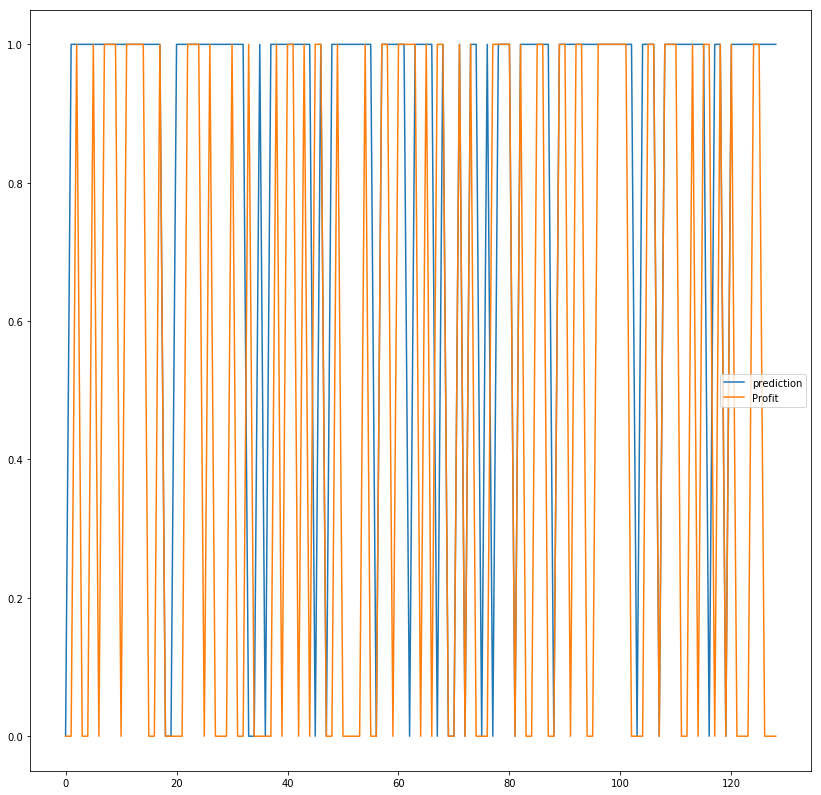

In [113]:
test = predictions_rt.toPandas()
csv_buffer = StringIO()
test.to_csv(csv_buffer)

s3_resource = boto3.resource('s3')

s3_resource.Object('logs102', 'DT_Final.csv').put(Body=csv_buffer.getvalue())

if DEBUG != True:
    df_to_plot_rt = predictions_rt.select('prediction', 'Profit')
    print(df_to_plot_rt)
    df_to_plot_rt = df_to_plot_rt.toPandas()
    plt_dt.figure(figsize=(14, 14))
    plt_dt.plot(df_to_plot_rt)
    plt_dt.legend(df_to_plot_rt.columns)
    plt_dt.show()